# Lab N
### Morphology

Skimage morphology operators' documentation:
https://scikit-image.org/docs/dev/api/skimage.morphology.html

In [2]:
from commonfunctions import *
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.morphology import binary_erosion, binary_dilation, binary_closing,skeletonize, thin
from skimage.measure import find_contours
from skimage.draw import rectangle
from skimage.filters import try_all_threshold

# Show the figures / plots inside the notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
def erode_this(image_file, erosion_level=3):
    erosion_level = 3 if erosion_level < 3 else erosion_level

    structuring_kernel = np.full(shape=(erosion_level, erosion_level), fill_value=1)
    image_src = image_file

    orig_shape = image_src.shape
    pad_width = int(erosion_level/2)

    # pad the matrix with `pad_width`
    image_pad = np.pad(array=image_src, pad_width=pad_width, mode='constant')
    pimg_shape = image_pad.shape
    h_reduce, w_reduce = (pimg_shape[0] - orig_shape[0]), (pimg_shape[1] - orig_shape[1])

    # sub matrices of kernel size
    flat_submatrices = np.array([
        image_pad[i:(i + erosion_level), j:(j + erosion_level)]
        for i in range(pimg_shape[0] - h_reduce) for j in range(pimg_shape[1] - w_reduce)
    ])

    # condition to replace the values - if the kernel equal to submatrix then 1 else 0
    image_erode = np.array([1 if (i.min() == 1) else 0 for i in flat_submatrices])
    image_erode = image_erode.reshape(orig_shape)
    
    return image_erode

In [4]:
def dilate_this(image_file, dilation_level=3):
    # setting the dilation_level
    dilation_level = 3 if dilation_level < 3 else dilation_level

    # obtain the kernel by the shape of (dilation_level, dilation_level)
    structuring_kernel = np.full(shape=(dilation_level, dilation_level), fill_value=1)
    
    image_src = image_file

    orig_shape = image_src.shape
    pad_width = int(dilation_level/2)

    # pad the image with pad_width
    image_pad = np.pad(array=image_src, pad_width=pad_width, mode='constant', constant_values=(0,0))
    pimg_shape = image_pad.shape
    h_reduce, w_reduce = (pimg_shape[0] - orig_shape[0]), (pimg_shape[1] - orig_shape[1])

    # obtain the submatrices according to the size of the kernel
    flat_submatrices = np.array([
        image_pad[i:(i + dilation_level), j:(j + dilation_level)]
        for i in range(pimg_shape[0] - h_reduce) for j in range(pimg_shape[1] - w_reduce)
    ])

    # replace the values either 1 or 0 by dilation condition
    image_dilate = np.array([1 if (i.max()==1) else 0 for i in flat_submatrices])
    # obtain new matrix whose shape is equal to the original image size
    image_dilate = image_dilate.reshape(orig_shape)
    
    return image_dilate

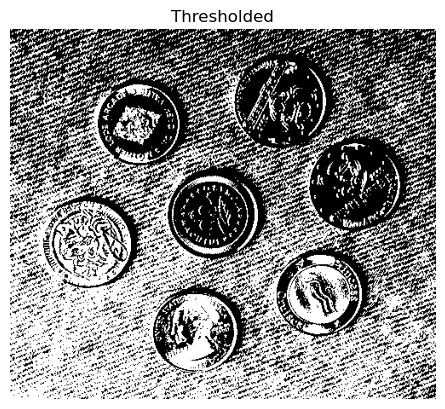

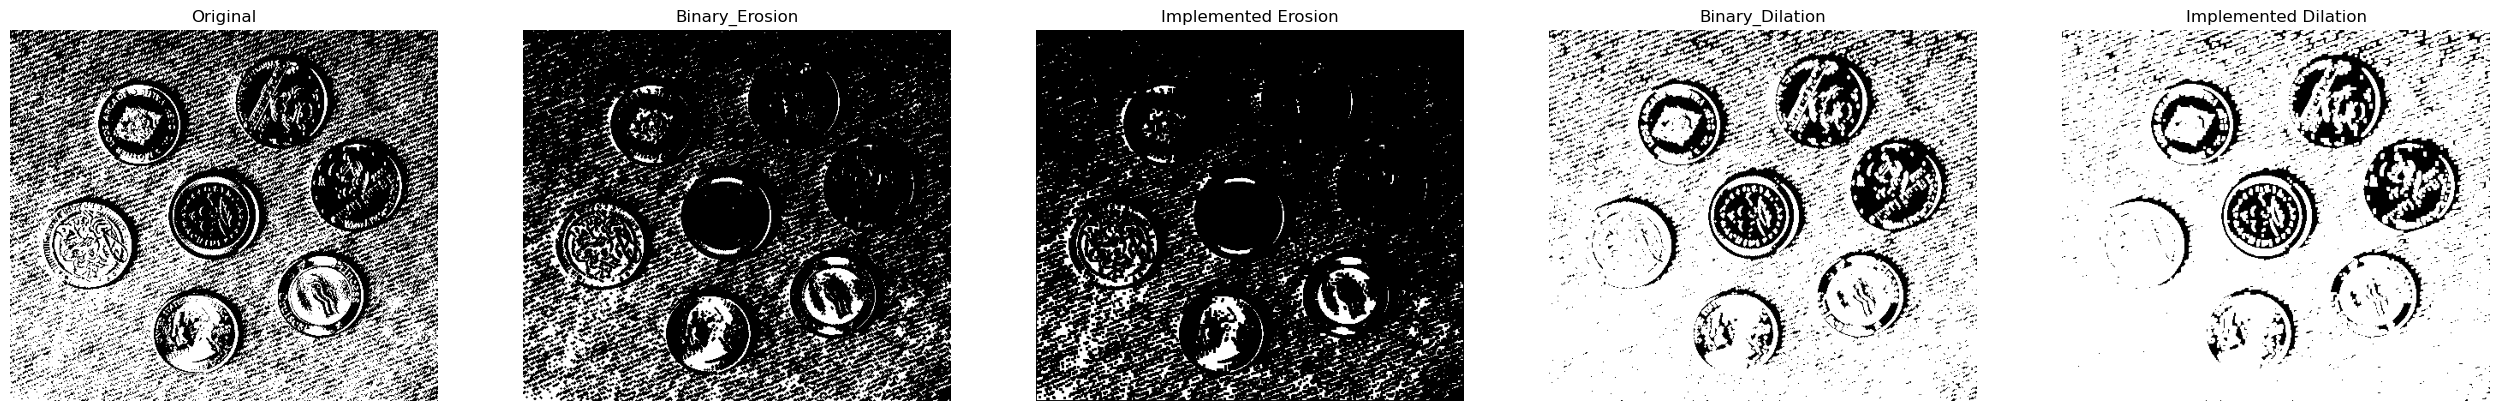

In [5]:
'''
1) Erosion / Dilation:
    - Load "coins.jpg" from the img folder
    - Convert the image to binary
    - Write 2 functions each applying 1 of the erosion/dilation algorithms (with adjustable square window size) manually to the binary image
    - Use Skimage's "binary_erosion" & "binary_dilation" & show the results
'''

img = rgb2gray(io.imread('img/coins.jpg'))

#Binarize
img[img>=0.577] = 1
img[img<0.577] = 0
show_images([img], ['Thresholded'])

#Implemented Erode
ero = erode_this(img, 3)

dilat = dilate_this(img, 3)

#Skiimage Erode
erode = binary_erosion(img)

#skiimage Dilation
dil = binary_dilation(img)

show_images([img, erode, ero ,dil, dilat], ['Original', 'Binary_Erosion', 'Implemented Erosion', 'Binary_Dilation', 'Implemented Dilation'])


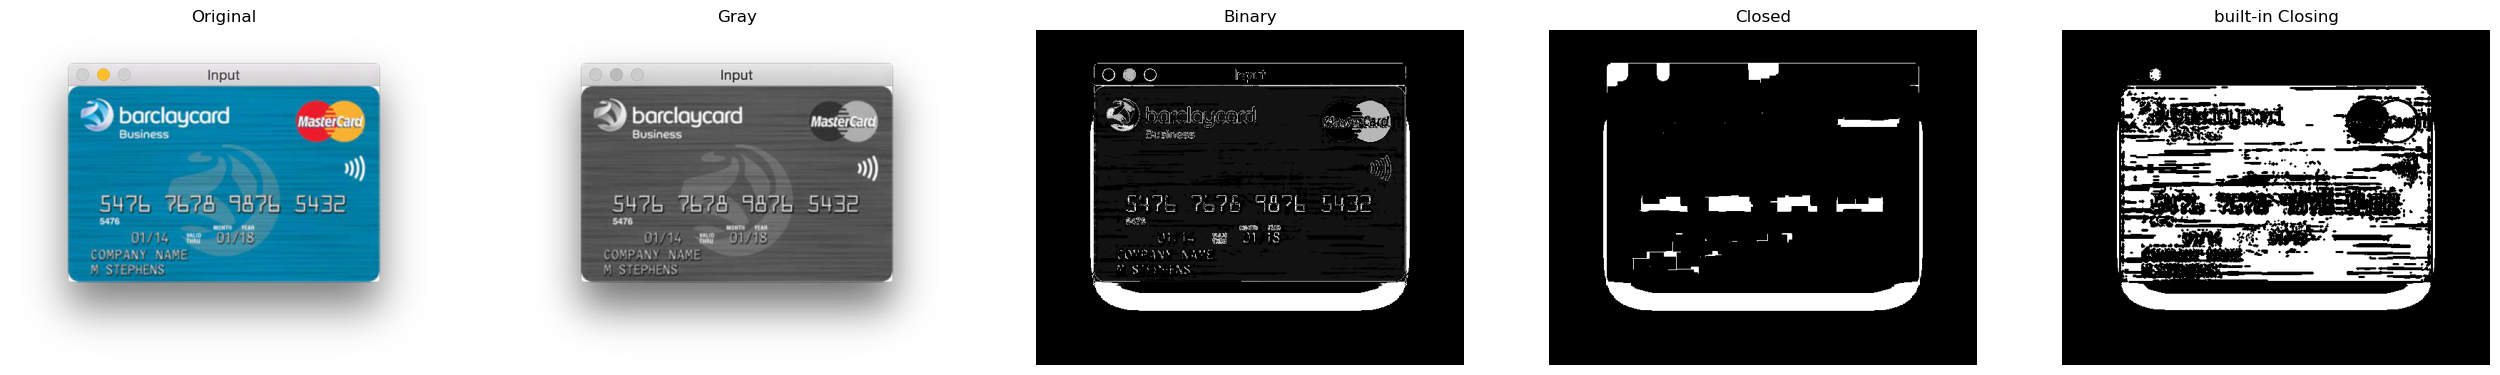

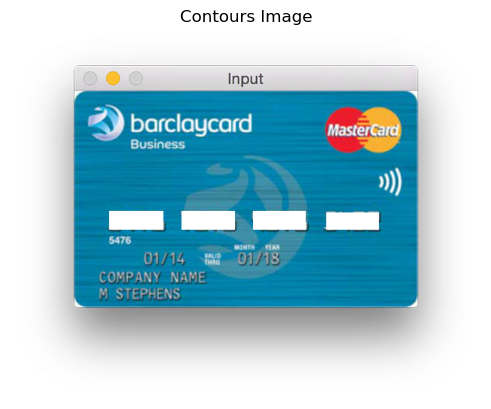

In [6]:
'''
2) Case Study: Credit Card Number Extraction
    - Load "card.jpg" from the img folder
    - Convert the image to binary by brightness thresholding maintaining the card number details for extraction
    - Use your erosion/dilation functions, or Skimage's functions only if you didn't implement them, to apply closing
        Note: The goal of this step is to join the card number into 4 sets of connected pixels
    - Use Skimage's "find_contours" to get the bounding boxes for the credit card's numbers by filtering on aspect ratio (between 2.5 & 3.5)
        Note: When using "find_contours(img, 0.8)" the o/p is a list of contours each having:
                - contour[:,0] being the Y values of the contour perimeter points
                - contour[:,1] being the X values of the contour perimeter points
'''
img = io.imread('img/card.jpg')
# show_images([img])
img1 = rgb2gray(io.imread('img/card.jpg'))
img2 = np.copy(img)
img2[img2<160] = 0
img2[img2>200] = 0
img2[img2>=160] = 255
img2 = rgb2gray(img2)

dil = dilate_this(img2, 17)
closed = erode_this(dil, 17)

dil2 = binary_dilation(img2)
er =  binary_erosion(img2)
show_images([img, img1, img2, closed, er], ['Original', 'Gray', 'Binary', 'Closed', 'built-in Closing'])
show_images([closed], ['Closed'])

bounding_boxes = []
contours = find_contours(closed, 0.8)
for i in range(0, len(contours)):
    curr_contour = contours[i]
    x = curr_contour[:, 1]
    y = curr_contour[:, 0]
    bounding_boxes.append([int(x.min()), int(x.max()), int(y.min()), int(y.max())])
img_with_boxes = np.copy(img)

#When provided with the correct format of the list of bounding_boxes, this section will set all pixels inside boxes in img_with_boxes
for box in bounding_boxes:
        
    [Xmin, Xmax, Ymin, Ymax] = box
    if (Xmax-Xmin)/(Ymax-Ymin)>=2.5 and (Xmax-Xmin)/(Ymax-Ymin)<=3.5 and (Ymax-Ymin) > 20:
        rr, cc = rectangle(start = (Ymin,Xmin), end = (Ymax,Xmax), shape=img1.shape)

        img_with_boxes[rr, cc] = 255 #set color white

show_images([img_with_boxes], ['Contours Image'])

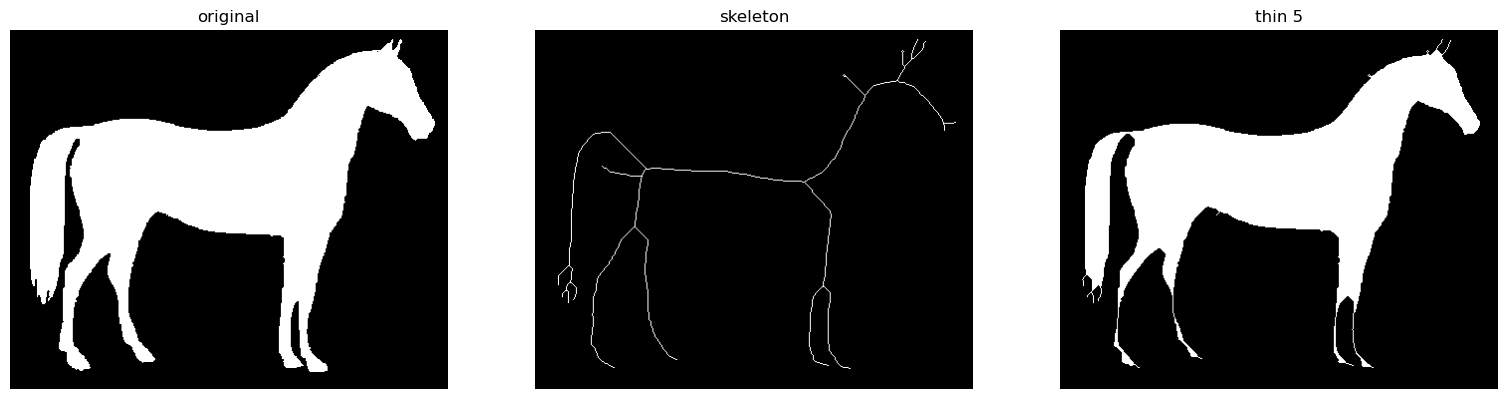

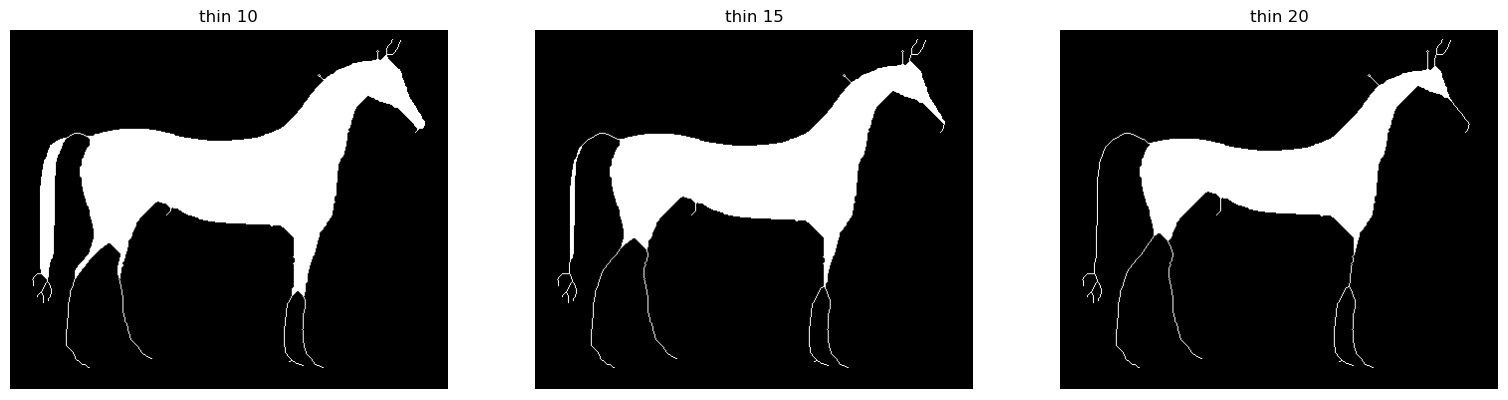

In [6]:
'''
3) Skeletonization:
    - Load "horse.jpg" from the img folder 
    - Use a binary threshold of 0.9 to remove invisible noise in the background
    - Use Skimage's "skeletonize(image)" to acquire the image's skeleton & show it
    - Use Skimage's "thin(image, max_iter)" with values of max_iter 5/10/15/20 & show it
'''
img = rgb2gray(io.imread('img/horse.jpg'))
img[img>=0.9] = 1
img[img<0.9] = 0

skel = skeletonize(img)
thinning1 = thin(img, max_num_iter = 5)
thinning2 = thin(img, max_num_iter = 10)
thinning3 = thin(img, max_num_iter = 15)
thinning4 = thin(img, max_num_iter = 20)
show_images([img, skel, thinning1], ['original', 'skeleton', 'thin 5',])
show_images([thinning2, thinning3, thinning4], ['thin 10', 'thin 15', 'thin 20'])